In [16]:
pip install Pillow

In [17]:
import numpy as np
import os
from imageio import imread
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof
import tensorflow as tf 

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

We set the random seed so that the results don't vary drastically.

In [18]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [19]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [21]:
project_folder='/content/gdrive/My Drive/Colab Notebooks/GestureRecognition/Project/Project_data'

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [22]:
train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
batch_size = 20
train_path = project_folder + '/' + 'train'
val_path =  project_folder + '/' + 'val'

In [ ]:
#image properties 
image_height=100
image_width=100
channels=3
num_classes=5
total_frames=30
frames_to_sample=30
batch_size=20
num_epochs=20
print ('# epochs =', num_epochs)

# epochs = 20


In [30]:
num_train_sequences = len(train_doc)

In [31]:
num_val_sequences = len(val_doc)

In [32]:
print('# training sequences =', num_train_sequences)

# training sequences = 663


In [33]:
print(num_val_sequences)
print('# validation sequences =', num_val_sequences)

100
# validation sequences = 100


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [18]:
img_idx = np.round(np.linspace(0,total_frames-1,frames_to_sample)).astype(int)
print(img_idx)

[ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]


In [10]:
def generator(source_path, folder_list, batch_size,augment = False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #create a list of image numbers you want to use for a particular video
    img_idx = np.round(np.linspace(0,total_frames-1,frames_to_sample)).astype(int)  
    while True:
        t = np.random.permutation(folder_list)
        # calculate the number of batches
        num_batches =  len(t)//batch_size
        for batch in range(num_batches): 
                batch_data, batch_labels= process_batch(source_path,t,batch,batch_size,img_idx)
                yield batch_data, batch_labels 

        remaining_seq=len(t)%batch_size
        
        if (remaining_seq != 0):
                batch_data, batch_labels= process_batch(source_path,t,num_batches,batch_size,img_idx,remaining_seq)
                yield batch_data, batch_labels       

    
        # write the code for the remaining data points which are left after full batches


In [11]:
def process_batch(source_path,t,batch,batch_size,img_idx,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),image_height,image_width,channels)) 
        batch_labels = np.zeros((seq_len,num_classes))    
        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes
                size=(image_height,image_width)
                image_resized=cv2.resize(image, size)          
                batch_data[folder,idx,:,:,0] =(image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1          
        return(batch_data,batch_labels)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [27]:
curr_dt_time = datetime.datetime.now()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

#write your model here

In [ ]:
#image properties 
image_height=160
image_width=160
channels=3
num_classes=5
total_frames=30
frames_to_sample=20
batch_size=40
num_epochs=15
dense_neurons=64
dropout=0.25
filtersize=(3,3,3)
print ('# epochs =', num_epochs)

# epochs = 15


In [41]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',
input_shape=(frames_to_sample,image_height,image_width,channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


In [42]:
model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

In [43]:
model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


In [44]:
model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

In [45]:
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

In [46]:
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

In [47]:
model.add(Dense(num_classes,activation='softmax'))

optimiser = 'adam'
        #optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [48]:
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 8, 60, 60, 32)    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [49]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [50]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [51]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [52]:
history_model1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/My Drive/Colab Notebooks/GestureRecognition/Project/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5398 - categorical_accuracy: 0.4208Source path =  /content/gdrive/My Drive/Colab Notebooks/GestureRecognition/Project/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-05-1519_52_59.500549/model-00001-1.53982-0.42081-4.30534-0.16000.h5
34/34 [==============================] - 48s 1s/step - loss: 1.5398 - categorical_accuracy: 0.4208 - val_loss: 4.3053 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9423 - categorical_accuracy: 0.6244
Epoch 2: saving model to model_init_2022-05-1519_52_59.500549/model-00002-0.94234-0.62443-5.90765-0.25000.h5
34/34 [==============================] - 46s 1s/step - loss: 0.9423 - categorical_accuracy: 0.6244 - val_loss: 5.9076 - val_categorical_accuracy: 0.2500 - lr: 0.0010


In [37]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

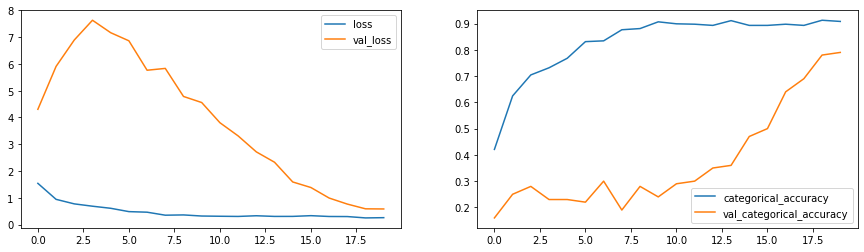

In [53]:
plot(history_model1)

### Model2

In [ ]:
#image properties 
image_height=120
image_width=120
channels=3
num_classes=5
total_frames=30
frames_to_sample=16
batch_size=30
num_epochs=25
dense_neurons=256
dropout=0.5
filtersize=(2,2,2)
print ('# epochs =', num_epochs)

# epochs = 25


In [ ]:
model2 = Sequential()
model2.add(Conv3D(16, filtersize, padding='same',
input_shape=(frames_to_sample,image_height,image_width,channels)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(32, filtersize, padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(64, filtersize, padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Conv3D(128, filtersize, padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Flatten())
model2.add(Dense(dense_neurons,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(dropout))

model2.add(Dense(dense_neurons,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(dropout))


model2.add(Dense(num_classes,activation='softmax'))
        
optimiser = tf.optimizers.Adam(lr=0.0002)
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  400       
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_5 (Activation)   (None, 8, 60, 60, 32)    

In [ ]:
print("Total Params:", model2.count_params())


Total Params: 1762613


In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history_model2 = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/My Drive/Colab Notebooks/GestureRecognition/Project/Project_data/train ; batch size = 30
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.0867 - categorical_accuracy: 0.3424 Source path =  /content/gdrive/My Drive/Colab Notebooks/GestureRecognition/Project/Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-05-1422_19_53.823618/model-00001-2.08672-0.34238-1.77903-0.16000.h5
23/23 [==============================] - 1010s 46s/step - loss: 2.0867 - categorical_accuracy: 0.3424 - val_loss: 1.7790 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.3285 - categorical_accuracy: 0.5490
Epoch 2: saving model to model_init_2022-05-1422_19_53.823618/model-00002-1.32853-0.54902-2.89311-0.15000.h5
23/23 [==============================] - 44s 2s/step - loss: 1.3285 - categorical_accuracy: 0.5490 - val_loss: 2.8931 - val_categorical_accuracy: 0.1500 - lr:

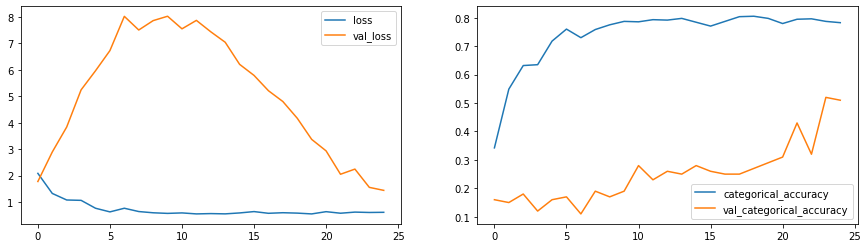

In [ ]:
plot(history_model2)

Model3

#### Reducing the number of parameters

In [ ]:
#image properties 
image_height=120
image_width=120
channels=3
num_classes=5
total_frames=30
frames_to_sample=16
batch_size=20
num_epochs=25
dense_neurons=64
dropout=0.25
filtersize=(3,3,3)
print ('# epochs =', num_epochs)

# epochs = 25


In [ ]:
model3 = Sequential()
model3.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(frames_to_sample,image_height,image_width,channels)))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(32, filtersize, padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(64, filtersize, padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(128, filtersize, padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
     
model3.add(Flatten())
model3.add(Dense(dense_neurons,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(dropout))

model3.add(Dense(dense_neurons,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(dropout))

model3.add(Dense(num_classes,activation='softmax'))

optimiser = tf.optimizers.Adam(lr=0.0002)
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_9 (Activation)   (None, 8, 60, 60, 32)    

In [ ]:
print("Total Params:", model3.count_params())

Total Params: 699269


In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history_model3 = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/My Drive/Colab Notebooks/GestureRecognition/Project/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.6466 - categorical_accuracy: 0.3846Source path =  /content/gdrive/My Drive/Colab Notebooks/GestureRecognition/Project/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-05-1422_19_53.823618/model-00001-1.64662-0.38462-1.86199-0.21000.h5
34/34 [==============================] - 48s 1s/step - loss: 1.6466 - categorical_accuracy: 0.3846 - val_loss: 1.8620 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1527 - categorical_accuracy: 0.5551
Epoch 2: saving model to model_init_2022-05-1422_19_53.823618/model-00002-1.15269-0.55505-2.29719-0.23000.h5
34/34 [==============================] - 45s 1s/step - loss: 1.1527 - categorical_accuracy: 0.5551 - val_loss: 2.2972 - val_categorical_accuracy: 0.2300 - lr: 2.0

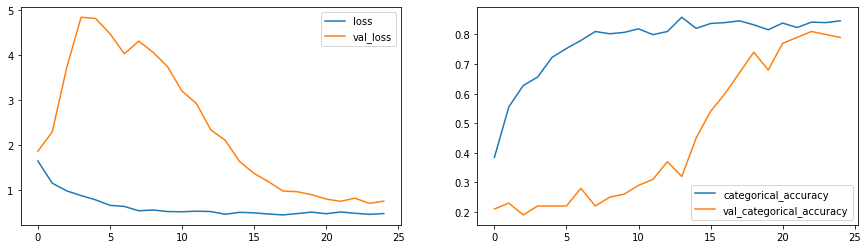

In [ ]:
plot(history_model3)

### Model 4

LSTM

In [ ]:
#image properties 
image_height=120
image_width=120
channels=3
num_classes=5
total_frames=30
frames_to_sample=18
batch_size=20
num_epochs=20
dense_neurons=128
lstm_cells=128
dropout=0.25
filtersize=(3,3,3)
print ('# epochs =', num_epochs)

# epochs = 20


In [ ]:
model4 = Sequential()

model4.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(frames_to_sample,image_height,image_width,channels)))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model4.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model4.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model4.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model4.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Flatten()))


model4.add(LSTM(lstm_cells))
model4.add(Dropout(dropout))
        
model4.add(Dense(dense_neurons,activation='relu'))
model4.add(Dropout(dropout))
        
model4.add(Dense(num_classes, activation='softmax'))
optimiser = tf.optimizers.Adam()
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)  

In [ ]:
print("Total Params:", model4.count_params())

Total Params: 1657445


In [26]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history_model4 = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/My Drive/Colab Notebooks/GestureRecognition/Project/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4137 - categorical_accuracy: 0.3952 Source path =  /content/gdrive/My Drive/Colab Notebooks/GestureRecognition/Project/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-05-1422_19_53.823618/model-00001-1.41366-0.39517-1.76341-0.18000.h5
34/34 [==============================] - 544s 16s/step - loss: 1.4137 - categorical_accuracy: 0.3952 - val_loss: 1.7634 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0770 - categorical_accuracy: 0.5762
Epoch 2: saving model to model_init_2022-05-1422_19_53.823618/model-00002-1.07697-0.57617-1.71093-0.26000.h5
34/34 [==============================] - 53s 2s/step - loss: 1.0770 - categorical_accuracy: 0.5762 - val_loss: 1.7109 - val_categorical_accuracy: 0.2600 - lr: 0.00

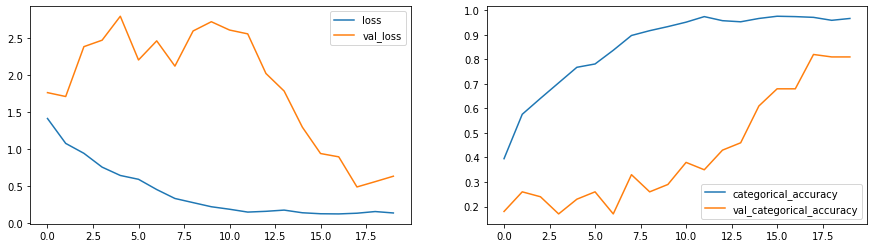

In [ ]:
plot(history_model4)

### Transfer Learning


### MobileNet 

In [2]:
from keras.applications import mobilenet

In [3]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

17235968/17225924 [==============================] - 0s 0us/step


In [5]:
#image properties 
image_height=120
image_width=120
channels=3
num_classes=5
total_frames=30
frames_to_sample=16
batch_size=5
num_epochs=20
dense_neurons=128
lstm_cells=128
dropout=0.25
print ('# epochs =', num_epochs)

# epochs = 20


In [13]:
model5 = Sequential()
model5.add(TimeDistributed(mobilenet_transfer,input_shape=(frames_to_sample,image_height,image_width,channels)))
for layer in model5.layers:
   layer.trainable = False

model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))
model5.add(TimeDistributed(Flatten()))
model5.add(LSTM(lstm_cells))
model5.add(Dropout(dropout))
        
model5.add(Dense(dense_neurons,activation='relu'))
model5.add(Dropout(dropout))
        
model5.add(Dense(num_classes, activation='softmax'))
        
        
optimiser = tf.optimizers.Adam()
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [14]:
model5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 16, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 128)              

In [16]:
print("Total Params:", model5.count_params())

Total Params: 3840453


In [27]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [28]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

In [34]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [35]:
history_model5 = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/My Drive/Colab Notebooks/GestureRecognition/Project/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4170 - categorical_accuracy: 0.4148  Source path =  /content/gdrive/My Drive/Colab Notebooks/GestureRecognition/Project/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-05-1510_40_50.432138/model-00001-1.41703-0.41478-1.05859-0.62000.h5
34/34 [==============================] - 8202s 248s/step - loss: 1.4170 - categorical_accuracy: 0.4148 - val_loss: 1.0586 - val_categorical_accuracy: 0.6200 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.7355 - categorical_accuracy: 0.7511
Epoch 2: saving model to model_init_2022-05-1510_40_50.432138/model-00002-0.73553-0.75113-0.69933-0.76000.h5
34/34 [==============================] - 46s 1s/step - loss: 0.7355 - categorical_accuracy: 0.7511 - val_loss: 0.6993 - val_categorical_accuracy: 0.7600 - lr: 0

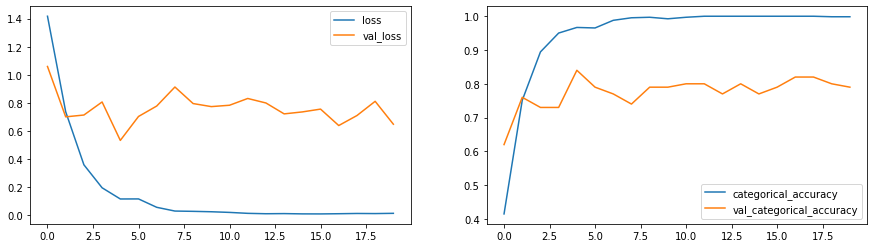

In [38]:
plot(history_model5)

### Model6

### RestNet  with Transfer Learning

In [3]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D,MaxPooling2D, GlobalAveragePooling2D

In [4]:
#image properties 
image_height=120
image_width=120
channels=3
num_classes=5
total_frames=30
frames_to_sample=16
batch_size=5
num_epochs=20
dense_neurons=128
lstm_cells=128
dropout=0.25
print ('# epochs =', num_epochs)

# epochs = 20


In [5]:
base_model = ResNet50(weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 0s 0us/step


In [8]:
model6 = Sequential()
model6.add(TimeDistributed(base_model,input_shape=(frames_to_sample,image_height,image_width,channels)))
for layer in model6.layers:
   layer.trainable = False
  
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))
model6.add(TimeDistributed(Flatten()))
model6.add(LSTM(lstm_cells))
model6.add(Dropout(dropout))
        
model6.add(Dense(dense_neurons,activation='relu'))
model6.add(Dropout(dropout))
        
model6.add(Dense(num_classes, activation='softmax'))
        
optimiser = 'adam'
        #optimiser = 'sgd'
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 4, 4, 2048)   23587712  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 4, 4, 2048)   8192      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 2, 2, 2048)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 8192)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               4

In [9]:
print("Total Params:", model6.count_params())

Total Params: 27873413


In [24]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [28]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
#callbacks_list = [checkpoint, LR]
callbacks_list =[checkpoint, LR]

In [34]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [35]:
history_model6 = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/My Drive/Colab Notebooks/GestureRecognition/Project/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5384 - categorical_accuracy: 0.2836  Source path =  /content/gdrive/My Drive/Colab Notebooks/GestureRecognition/Project/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-05-1519_52_59.500549/model-00001-1.53836-0.28356-1.51678-0.29000.h5
34/34 [==============================] - 5988s 181s/step - loss: 1.5384 - categorical_accuracy: 0.2836 - val_loss: 1.5168 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4082 - categorical_accuracy: 0.3680
Epoch 2: saving model to model_init_2022-05-1519_52_59.500549/model-00002-1.40825-0.36802-1.51568-0.25000.h5
34/34 [==============================] - 49s 1s/step - loss: 1.4082 - categorical_accuracy: 0.3680 - val_loss: 1.5157 - val_categorical_accuracy: 0.2500 - lr: 0

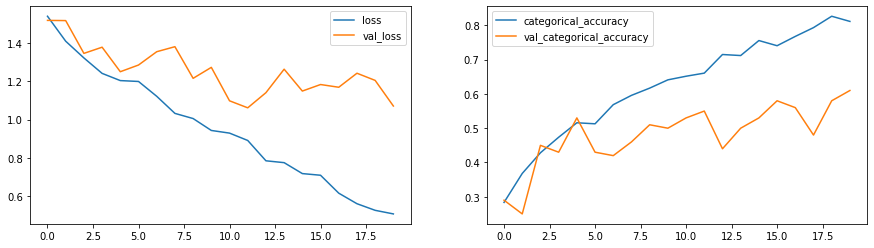

In [39]:
plot(history_model6)